In [21]:
import pandas as pd
import plotly.express as px

# === Load dataset ===
file_path = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\fish-seafood-production\fish-seafood-production.csv"
df = pd.read_csv(file_path)

# === Rename the long column ===
df.rename(columns={
    "Fish and seafood | 00002960 || Production | 005511 || tonnes": "Production(in tonnes)"
}, inplace=True)

# === Ensure numeric values ===
df["Production(in tonnes)"] = pd.to_numeric(df["Production(in tonnes)"], errors="coerce")

# === Remove aggregates (World, Melanesia, Polynesia, etc.) ===
df = df.dropna(subset=["Code"])
df = df[~df["Code"].str.startswith("OWID_")]

# === Use 2022 only ===
latest_year = 2022
latest_df = df[df["Year"] == latest_year].copy()

# === Define bins (categorical ranges) ===
bins = [0, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, latest_df["Production(in tonnes)"].max()]
labels = ["0–100k", "100k–300k", "300k–1M", "1M–3M", "3M–10M", "10M–30M", "30M+"]

latest_df["Production bins"] = pd.cut(
    latest_df["Production(in tonnes)"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# === Build choropleth ===
fig = px.choropleth(
    latest_df,
    locations="Code",
    color="Production bins",
    hover_name="Entity",
    projection="natural earth",
    category_orders={"Production bins": labels},
    color_discrete_sequence=[
        "#ffffcc", "#d9f0a3", "#addd8e", "#78c679",
        "#31a354", "#006837", "#004529"
    ],
    title=f"Fish and seafood production, {latest_year}",
    custom_data=["Production(in tonnes)", "Year"]
)

# === Styling & hover template ===
fig.update_traces(
    marker=dict(line=dict(color="white", width=0.3)),
    hovertemplate="<b>%{hovertext}</b><br>Production: %{customdata[0]:,} tonnes<br>Year: %{customdata[1]}<extra></extra>"
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        showland=True,
        landcolor="lightgrey",   # grey for no data
        projection_type="natural earth"
    ),
    margin={"r":0,"t":60,"l":0,"b":0},
    legend=dict(
        title="Production (tonnes)",
        orientation="h",
        x=0.5, xanchor="center",
        y=-0.15,
        itemsizing="constant"
    ),
    font=dict(size=14),
    width=1100,
    height=550
)

# === Add 'No data' legend entry ===
fig.add_scattergeo(
    locations=[""],  # dummy invisible trace
    mode="markers",
    marker=dict(color="lightgrey"),
    name="No data"
)

fig.show()


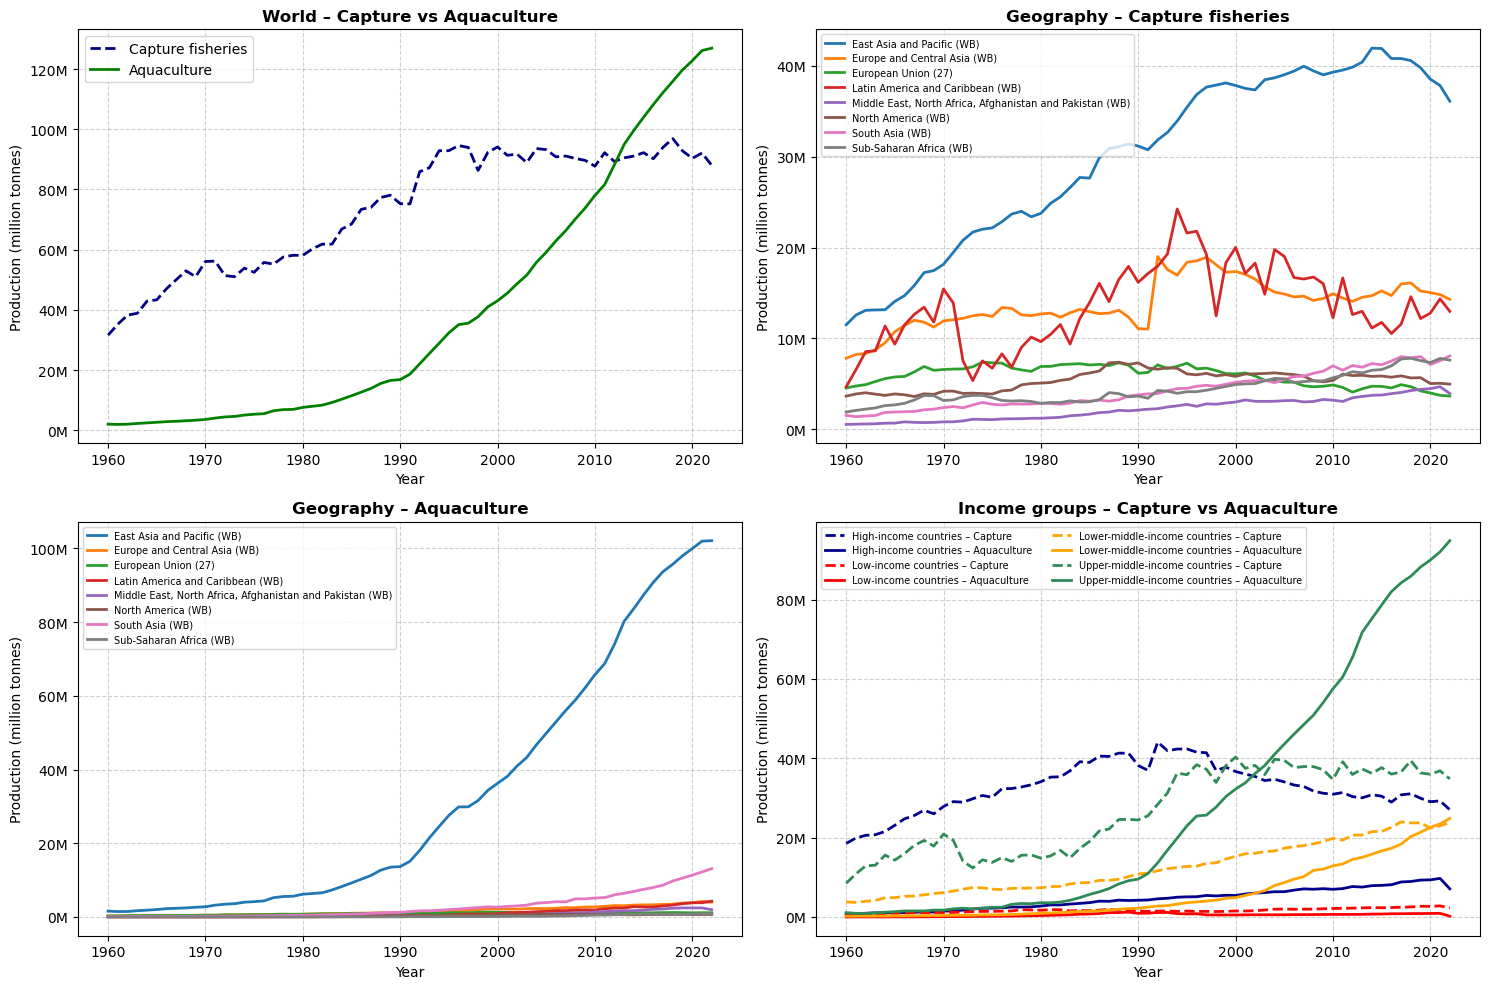

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# === File paths ===
capture_file = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\capture-fishery-production\capture-fishery-production.csv"
aqua_file = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\aquaculture-farmed-fish-production\aquaculture-farmed-fish-production.csv"

# === Load datasets ===
cap = pd.read_csv(capture_file)
aqua = pd.read_csv(aqua_file)

# === Rename production columns ===
cap.rename(columns={"Capture fisheries production (metric tons)": "Production (tonnes)"}, inplace=True)
aqua.rename(columns={"Aquaculture production (metric tons)": "Production (tonnes)"}, inplace=True)

# === Clean common ===
for df in [cap, aqua]:
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    df["Production (tonnes)"] = pd.to_numeric(df["Production (tonnes)"], errors="coerce")
    df["Entity"] = df["Entity"].astype(str).str.strip()
    df["Code"] = df["Code"].astype(str).str.strip().str.upper()
    df.dropna(subset=["Year", "Production (tonnes)"], inplace=True)

# === Categories ===
geography_entities = [
    "East Asia and Pacific (WB)",
    "Europe and Central Asia (WB)",
    "European Union (27)",
    "Latin America and Caribbean (WB)",
    "Middle East, North Africa, Afghanistan and Pakistan (WB)",
    "North America (WB)",
    "South Asia (WB)",
    "Sub-Saharan Africa (WB)"
]

income_entities = [
    "High-income countries",
    "Low-income countries",
    "Lower-middle-income countries",
    "Upper-middle-income countries"
]

# === Filter datasets ===
cap_geo = cap[cap["Entity"].isin(geography_entities)]
aqua_geo = aqua[aqua["Entity"].isin(geography_entities)]
cap_income = cap[cap["Entity"].isin(income_entities)]
aqua_income = aqua[aqua["Entity"].isin(income_entities)]
cap_world = cap[cap["Entity"]=="World"]
aqua_world = aqua[aqua["Entity"]=="World"]

# === Format axis ===
def millions(x, pos):
    return f"{x*1e-6:.0f}M"

# === Color palette for income groups ===
colors = {
    "High-income countries": "darkblue",
    "Upper-middle-income countries": "seagreen",
    "Lower-middle-income countries": "orange",
    "Low-income countries": "red"
}

# === Plot ===
plt.figure(figsize=(15,10))

# 1. World trends
plt.subplot(2,2,1)
plt.plot(cap_world["Year"], cap_world["Production (tonnes)"], color="navy", linewidth=2, linestyle="--", label="Capture fisheries")
plt.plot(aqua_world["Year"], aqua_world["Production (tonnes)"], color="green", linewidth=2, linestyle="-", label="Aquaculture")
plt.title("World – Capture vs Aquaculture", fontsize=12, weight="bold")
plt.xlabel("Year"); plt.ylabel("Production (million tonnes)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)

# 2. Geography – Capture
plt.subplot(2,2,2)
for region in geography_entities:
    df = cap_geo[cap_geo["Entity"]==region]
    plt.plot(df["Year"], df["Production (tonnes)"], linewidth=2, label=region)
plt.title("Geography – Capture fisheries", fontsize=12, weight="bold")
plt.xlabel("Year"); plt.ylabel("Production (million tonnes)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.legend(fontsize=7, loc="upper left"); plt.grid(True, linestyle="--", alpha=0.6)

# 3. Geography – Aquaculture
plt.subplot(2,2,3)
for region in geography_entities:
    df = aqua_geo[aqua_geo["Entity"]==region]
    plt.plot(df["Year"], df["Production (tonnes)"], linewidth=2, label=region)
plt.title("Geography – Aquaculture", fontsize=12, weight="bold")
plt.xlabel("Year"); plt.ylabel("Production (million tonnes)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.legend(fontsize=7, loc="upper left"); plt.grid(True, linestyle="--", alpha=0.6)

# 4. Income groups – Capture vs Aquaculture
plt.subplot(2,2,4)
for group in income_entities:
    # Capture
    df_c = cap_income[cap_income["Entity"]==group]
    plt.plot(df_c["Year"], df_c["Production (tonnes)"], linewidth=2, linestyle="--",
             color=colors[group], label=f"{group} – Capture")
    # Aquaculture
    df_a = aqua_income[aqua_income["Entity"]==group]
    plt.plot(df_a["Year"], df_a["Production (tonnes)"], linewidth=2, linestyle="-",
             color=colors[group], label=f"{group} – Aquaculture")

plt.title("Income groups – Capture vs Aquaculture", fontsize=12, weight="bold")
plt.xlabel("Year"); plt.ylabel("Production (million tonnes)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.legend(fontsize=7, loc="upper left", ncol=2); plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


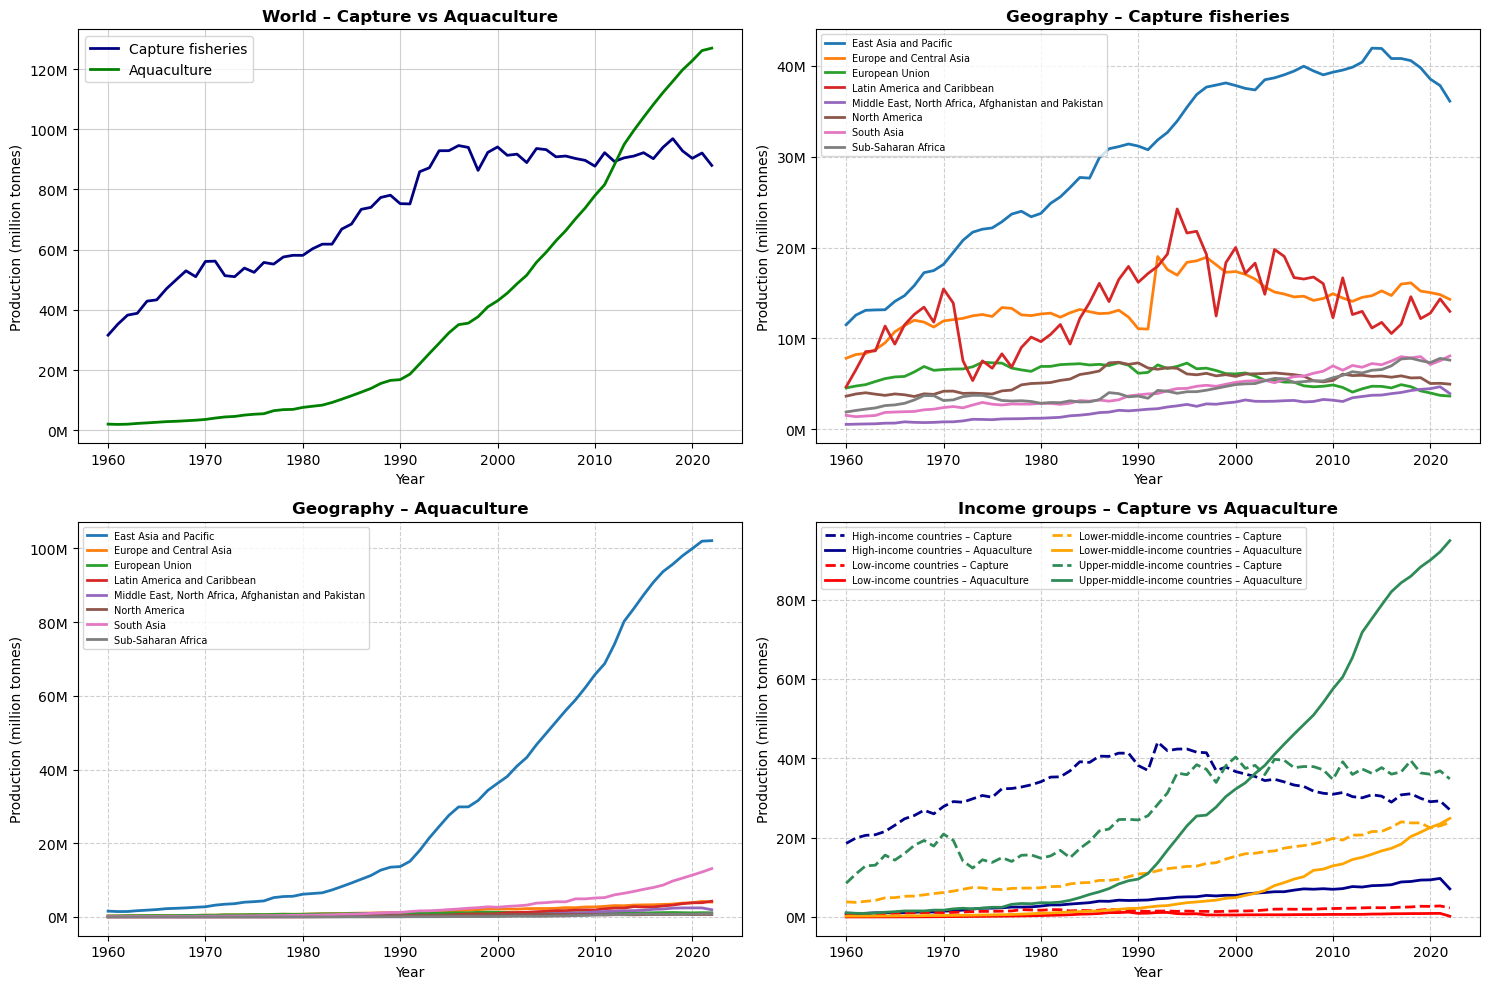

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# === File paths ===
capture_file = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\capture-fishery-production\capture-fishery-production.csv"
aqua_file = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\aquaculture-farmed-fish-production\aquaculture-farmed-fish-production.csv"

# === Load datasets ===
cap = pd.read_csv(capture_file)
aqua = pd.read_csv(aqua_file)

# === Rename production columns ===
cap.rename(columns={"Capture fisheries production (metric tons)": "Production (tonnes)"}, inplace=True)
aqua.rename(columns={"Aquaculture production (metric tons)": "Production (tonnes)"}, inplace=True)

# === Clean common ===
for df in [cap, aqua]:
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    df["Production (tonnes)"] = pd.to_numeric(df["Production (tonnes)"], errors="coerce")
    df["Entity"] = df["Entity"].astype(str).str.strip()
    df["Code"] = df["Code"].astype(str).str.strip().str.upper()
    df.dropna(subset=["Year", "Production (tonnes)"], inplace=True)

# === Clean labels for regions ===
label_map = {
    "East Asia and Pacific (WB)": "East Asia and Pacific",
    "Europe and Central Asia (WB)": "Europe and Central Asia",
    "European Union (27)": "European Union",
    "Latin America and Caribbean (WB)": "Latin America and Caribbean",
    "Middle East, North Africa, Afghanistan and Pakistan (WB)": "Middle East, North Africa, Afghanistan and Pakistan",
    "North America (WB)": "North America",
    "South Asia (WB)": "South Asia",
    "Sub-Saharan Africa (WB)": "Sub-Saharan Africa"
}

cap["Entity"] = cap["Entity"].replace(label_map)
aqua["Entity"] = aqua["Entity"].replace(label_map)

# === Categories ===
geography_entities = list(label_map.values())

income_entities = [
    "High-income countries",
    "Low-income countries",
    "Lower-middle-income countries",
    "Upper-middle-income countries"
]

# === Filter datasets ===
cap_geo = cap[cap["Entity"].isin(geography_entities)]
aqua_geo = aqua[aqua["Entity"].isin(geography_entities)]
cap_income = cap[cap["Entity"].isin(income_entities)]
aqua_income = aqua[aqua["Entity"].isin(income_entities)]
cap_world = cap[cap["Entity"]=="World"]
aqua_world = aqua[aqua["Entity"]=="World"]

# === Format axis ===
def millions(x, pos):
    return f"{x*1e-6:.0f}M"

# === Color palette for income groups ===
colors = {
    "High-income countries": "darkblue",
    "Upper-middle-income countries": "seagreen",
    "Lower-middle-income countries": "orange",
    "Low-income countries": "red"
}

# === Plot ===
plt.figure(figsize=(15,10))

# 1. World trends
plt.subplot(2,2,1)
plt.plot(cap_world["Year"], cap_world["Production (tonnes)"], color="navy", linewidth=2, label="Capture fisheries")
plt.plot(aqua_world["Year"], aqua_world["Production (tonnes)"], color="green", linewidth=2, label="Aquaculture")
plt.title("World – Capture vs Aquaculture", fontsize=12, weight="bold")
plt.xlabel("Year"); plt.ylabel("Production (million tonnes)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.legend(); plt.grid(True, alpha=0.6)

# 2. Geography – Capture
plt.subplot(2,2,2)
for region in geography_entities:
    df = cap_geo[cap_geo["Entity"]==region]
    plt.plot(df["Year"], df["Production (tonnes)"], linewidth=2, label=region)
plt.title("Geography – Capture fisheries", fontsize=12, weight="bold")
plt.xlabel("Year"); plt.ylabel("Production (million tonnes)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.legend(fontsize=7, loc="upper left"); plt.grid(True, linestyle="--", alpha=0.6)

# 3. Geography – Aquaculture
plt.subplot(2,2,3)
for region in geography_entities:
    df = aqua_geo[aqua_geo["Entity"]==region]
    plt.plot(df["Year"], df["Production (tonnes)"], linewidth=2, label=region)
plt.title("Geography – Aquaculture", fontsize=12, weight="bold")
plt.xlabel("Year"); plt.ylabel("Production (million tonnes)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.legend(fontsize=7, loc="upper left"); plt.grid(True, linestyle="--", alpha=0.6)

# 4. Income groups – Capture vs Aquaculture
plt.subplot(2,2,4)
for group in income_entities:
    # Capture
    df_c = cap_income[cap_income["Entity"]==group]
    plt.plot(df_c["Year"], df_c["Production (tonnes)"], linewidth=2, linestyle="--",
             color=colors[group], label=f"{group} – Capture")
    # Aquaculture
    df_a = aqua_income[aqua_income["Entity"]==group]
    plt.plot(df_a["Year"], df_a["Production (tonnes)"], linewidth=2, linestyle="-",
             color=colors[group], label=f"{group} – Aquaculture")

plt.title("Income groups – Capture vs Aquaculture", fontsize=12, weight="bold")
plt.xlabel("Year"); plt.ylabel("Production (million tonnes)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.legend(fontsize=7, loc="upper left", ncol=2); plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [32]:
import pandas as pd
import plotly.express as px
import numpy as np

def plot_map(file_path, value_col, title):
    # Load data
    df = pd.read_csv(file_path)

    # Rename column
    df = df.rename(columns={value_col: "Production (tonnes)"})
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    df["Production (tonnes)"] = pd.to_numeric(df["Production (tonnes)"], errors="coerce")
    df["Entity"] = df["Entity"].astype(str).str.strip()
    df["Code"] = df["Code"].astype(str).str.strip().str.upper()

    # Remove aggregates
    df = df[~df["Code"].str.startswith("OWID_")]
    df = df[df["Entity"].str.lower() != "world"]

    # Hybrid rule: 2022 or latest available
    target_year = 2022
    df_2022 = df[df["Year"] == target_year]
    df_latest = df.sort_values("Year").groupby("Code", as_index=False).tail(1)
    df_latest = df_latest[~df_latest["Code"].isin(df_2022["Code"])]
    final_df = pd.concat([df_2022, df_latest], ignore_index=True)

    # Log transform for color scaling
    final_df["LogProd"] = np.log10(final_df["Production (tonnes)"] + 1)

    # Choropleth
    fig = px.choropleth(
        final_df,
        locations="Code",
        color="LogProd",
        hover_name="Entity",
        projection="natural earth",
        color_continuous_scale="YlGnBu",
        title=title,
        custom_data=["Production (tonnes)", "Year"]
    )

    # Hover text
    fig.update_traces(
        marker=dict(line=dict(color="white", width=0.3)),
        hovertemplate="<b>%{hovertext}</b><br>Supply: %{customdata[0]:,.0f} tonnes<br>Year: %{customdata[1]}<extra></extra>"
    )

    # Layout adjustments for better map fill
    fig.update_layout(
        geo=dict(
            showframe=False,
            showcoastlines=False,
            showland=True,
            landcolor="lightgrey",
            projection_type="natural earth",
            fitbounds="locations",   # fit to countries with data
            projection_scale=1.2     # zoom in map
        ),
        margin={"r":10,"t":50,"l":10,"b":60},  # reduce whitespace
        coloraxis_colorbar=dict(
            title="Tonnes",
            orientation="h",         # horizontal bar
            y=-0.1,                  # below map
            x=0.5, xanchor="center",
            len=0.4,                 # shorter
            thickness=10,            # thinner
            tickvals=[3, 5, 6, 7],   # log10 values
            ticktext=["1k", "100k", "1M", "10M"],
            titlefont=dict(size=12),
            tickfont=dict(size=11)
        ),
        font=dict(size=14),
        width=900,
        height=500,
        legend=dict(
            orientation="h",
            y=-0.2,                  # place legend below scale
            x=0.5,
            xanchor="center"
        )
    )

    # Force "No data" legend entry
    fig.add_scattergeo(
        locations=[""],  # dummy
        mode="markers",
        marker=dict(color="lightgrey", size=12, symbol="square"),
        name="No data",
        showlegend=True
    )

    fig.show()


# === File paths ===
capture_file = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\capture-fishery-production\capture-fishery-production.csv"
aquaculture_file = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\aquaculture-farmed-fish-production\aquaculture-farmed-fish-production.csv"

# === Plot both ===
plot_map(capture_file, "Capture fisheries production (metric tons)",
         "Global Wild-Caught Fish Supply (2022)")

plot_map(aquaculture_file, "Aquaculture production (metric tons)",
         "Global Aquaculture Supply (2022)")
